# Modelling

Two different models are assessed to understand how well they could predict weekly sales distribution. XGBoost is selected as the baseline model. The other 2 algorithms are ARIMA and Neural Networks.

This script prepares the data for modelling and can be used to run ARIMA and Neural Netowrk for weekly sales forcast. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import json

# import xgboost as xgb

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pmdarima import auto_arima
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '\config-example.json', 'r') as f:
    config = json.load(f)

dataset_EDA_fname = config['DEFAULT']['dataset_EDA_fname']
processing_path = config['DEFAULT']['processing_path']
dataset_fname_suffix = config['DEFAULT']['dataset_fname_suffix']

In [ ]:
client_data = pd.read_csv(os.path.join(processing_path,dataset_EDA_fname) + dataset_fname_suffix, header = 0, delimiter = ',')

In [182]:
client_data['StartDate'] = pd.to_datetime(client_data['StartDate'], infer_datetime_format=True)
client_data['StatusCreatedDate'] = pd.to_datetime(client_data['StatusCreatedDate'], infer_datetime_format=True)

# ARIMA Model
Use an ARIMA model to predict weekly sales Consider 30 percent of
data for testing. 

In [ ]:
arima_client_data = client_data.groupby(['StatusCreatedDate'], as_index=False).agg(
                                                                                            Min_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            Max_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            )
arima_client_data['Max_Week'] = arima_client_data['Max_Purchase_Week_Date'].dt.week
arima_client_data['Min_Week'] = arima_client_data['Min_Purchase_Week_Date'].dt.week

# Set the StartDate as index
arima_client_data = arima_client_data.set_index('StatusCreatedDate')

arima_client_data = arima_client_data.groupby([pd.Grouper(level='StatusCreatedDate', freq='W')]).sum()

#dropping rows with Null values
arima_client_data.dropna(inplace=True)

arima_client_data['Num_of_ticket'].plot(legend=True, figsize=(20,5), xlabel = 'Booking Dates', ylabel='Number of bookings', title='Weekly ticket sales for events')       

### Normalizing the Dataset

The different features in the dataset are on diffeberent scales of values. It's always best practice to scale all features to be on the same range of values so as to help the machine learning algorithm do better during training. Here, we use the `StandardScaler` to normalize all features to have values between -1 and +1.

In [61]:
cols_to_normalize = ['Max_Week', 'Min_Week', 'Num_of_ticket']

# Instantiate the standard scaler
sc = StandardScaler()

for col in cols_to_normalize:
    arima_client_data[col] = sc.fit_transform(arima_client_data[[col]])

Use an ARIMA model to predict the weekly sales (Number of tickets). Consider 30 percent of data for testing. 

In [62]:
# Check if dataset is stationary
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(arima_client_data['Num_of_ticket'])

1. ADF :  -5.086290765263727
2. P-Value :  1.493667338083903e-05
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 310
5. Critical Values :
	 1% :  -3.451621854687657
	 5% :  -2.870908950689806
	 10% :  -2.571761810613944


In [63]:
# using auto arima to predict best p, d, q values
stepwise_fit = auto_arima(arima_client_data['Num_of_ticket'], trace=True,
                         suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=806.290, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=895.093, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=813.253, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=829.356, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=893.093, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=804.304, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=819.909, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=813.522, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=806.266, Time=0.34 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=821.753, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=807.107, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=807.163, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=802.328, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=817.909, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=811.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  314
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -397.164
Date:                Sat, 25 Mar 2023   AIC                            802.328
Time:                        12:47:23   BIC                            817.326
Sample:                    01-15-2017   HQIC                           808.321
                         - 01-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9035      0.076     11.838      0.000       0.754       1.053
ma.L1         -0.4735      0.089     -5.344      0.000      -0.647      -0.300
ma.L2         -0.2080      0.060     -3.456      0.001      -0.326      -0.090
sigma2         0.7338      0.013     58.670      0.000       0.709       0.758
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             62541.38
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             6.16
Prob(H) (two-sided):                  0.23   Kurtosis:                        71.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
# Split dataset 
split_size = int(0.7*len(arima_client_data))

train_client_data = arima_client_data.iloc[:split_size, :]
test_client_data = arima_client_data.iloc[split_size:, :]

In [65]:
# Fit ARIMA model on best p, d, q values
model = sm.tsa.arima.ARIMA(train_client_data["Num_of_ticket"], order=(1,0,2))
arima_model = model.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Num_of_ticket   No. Observations:                  219
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -297.457
Date:                Sat, 25 Mar 2023   AIC                            604.915
Time:                        12:47:23   BIC                            621.860
Sample:                    01-15-2017   HQIC                           611.759
                         - 03-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0073      0.393     -0.019      0.985      -0.777       0.762
ar.L1          0.8900      0.114      7.791      0.000       0.666       1.114
ma.L1         -0.4556      0.126     -3.625      0.000      -0.702      -0.209
ma.L2         -0.2019      0.081     -2.504      0.012      -0.360      -0.044
sigma2         0.8842      0.025     35.468      0.000       0.835       0.933
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42160.30
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               9.88   Skew:                             6.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        69.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='StatusCreatedDate', ylabel='Average ticket booking'>

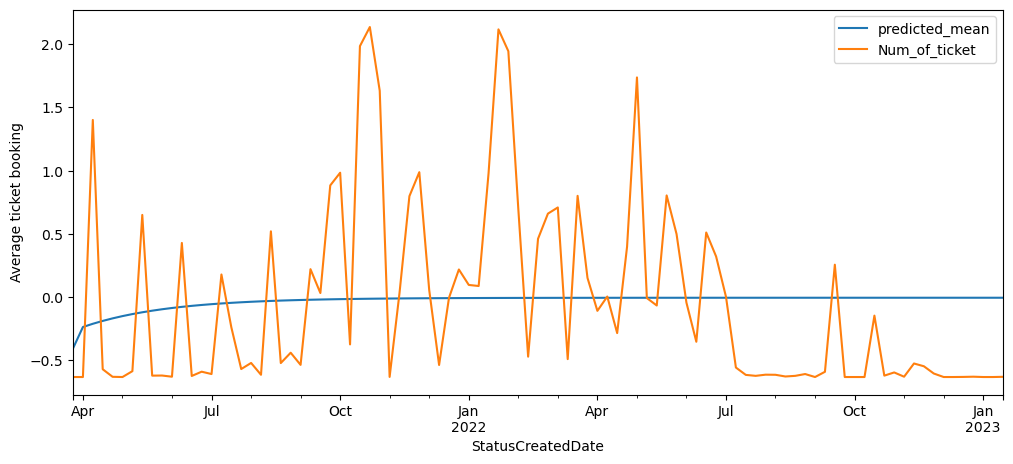

In [66]:
start_index = len(train_client_data)
stop_index = len(train_client_data) + len(test_client_data)-1

# prediction on test length
pred = arima_model.predict(start=start_index, end=stop_index)
pred.index=arima_client_data.index[start_index:stop_index+1]
# print(pred)

pred.plot(legend=True, figsize=(20,10), xlabel = 'Week', ylabel='Average ticket booking' )
test_client_data['Num_of_ticket'].plot(legend=True, figsize=(12,5))


In [67]:
arima_client_data['Num_of_ticket'].mean()

7.637202971943752e-17

In [68]:
mse = mean_squared_error(test_client_data["Num_of_ticket"], pred)

print(f"Mean Squared Error for ARIMA model is {round(mse, 3)}")

# print("prediction on weekly average of demand rate")
# pred[:6]

Mean Squared Error for ARIMA model is 0.531


# Nueral Networks

In [19]:
NN_client_data = client_data

NN_client_data

,StatusCreatedDate,StartDate,EventType,Weeks to Event,Num_of_ticket
0,2017-01-11 16:00:00,2017-11-27 00:00:00,"Others, Group 1",46.0,4
1,2017-01-11 16:02:00,2017-11-27 00:00:00,"Others, Group 1",46.0,2
2,2017-01-11 16:20:00,2017-11-25 00:00:00,"Others, Group 1",45.0,2
3,2017-01-11 16:56:00,2017-11-27 00:00:00,"Others, Group 1",46.0,2
4,2017-01-11 17:14:00,2017-11-25 00:00:00,"Others, Group 1",45.0,2
...,...,...,...,...,...
211932,2022-12-20 09:07:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211933,2022-12-20 11:18:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211934,2022-12-21 13:38:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211935,2023-01-13 13:47:00,2023-01-17 14:30:00,"Others, Group 10",1.0,2


### Feature Collection

In [ ]:
def create_features1(df):
    '''
    Create time series features based on time series StatusCreatedDate.dt
    '''
    # df['StatusCreatedWeek'] = df.StatusCreatedDate.dt.week
    # df = df.copy()
    # df['StatusCreatedHour'] = df.StatusCreatedDate.dt.hour
    # df['StatusCreatedDayofWeek'] = df.StatusCreatedDate.dt.dayofweek
    df['StatusCreatedQuarter'] = df.StatusCreatedDate.dt.quarter
    # df['StatusCreatedDayofyear'] = df.StatusCreatedDate.dt.dayofyear
    df['StatusCreatedMonth'] = df.StatusCreatedDate.dt.month
    df['StatusCreatedYear'] = df.StatusCreatedDate.dt.year
    # df['StatusCreatedDayofMonth'] = df.StatusCreatedDate.dt.day
    df['StatusCreatedWeekofYear'] = df.StatusCreatedDate.dt.weekofyear
    return df

### Encoding Categorical Varibles
When training a machine learning model, all categorical variables must be convert into numeric form. Here, the `LabelEncoder` is used.

In [21]:
categorical_col = NN_client_data.columns[NN_client_data.dtypes == "object"].to_list()
categorical_col

['EventType']

In [22]:
LE = LabelEncoder()

decode = pd.DataFrame(NN_client_data[categorical_col[0]].unique())
# decode3 = pd.DataFrame(NN_client_data[categorical_col[1]].unique())

for col2 in categorical_col:
    # Transoform to numeric form
    NN_client_data[col2] = LE.fit_transform(NN_client_data[col2])

decoded = pd.DataFrame(NN_client_data[categorical_col[0]].unique())
# decoded3 = pd.DataFrame(NN_client_data[categorical_col[1]].unique())

final_df = pd.DataFrame()
# final_df3 = pd.DataFrame()
final_df['decode'] = decode
final_df['decoded'] = decoded
# final_df3['decode3'] = decode3
# final_df3['decoded3'] = decoded3


dict_encoder = {}

for item in decoded[0]:
    dict_encoder[final_df.iloc[item]['decode']] = item
    
with open("NN_eventtype_encoder.json", "a") as write_file:
    json.dump(dict_encoder, write_file, indent=4,sort_keys=True)

print(final_df)

                    decode  decoded
0              Colloquium         0
1   Conference / Symposium        1
2               Exhibition        2
3                  Lecture        3
4        Lunchtime Lecture        4
5             Other Events        5
6          Others, Group 1        6
7         Others, Group 10        7
8          Others, Group 2        8
9          Others, Group 3        9
10         Others, Group 4       10
11         Others, Group 5       11
12         Others, Group 6       12
13         Others, Group 7       13
14         Others, Group 8       14
15         Others, Group 9       15
16           Reading Group       16
17       Research Training       17
18                 Seminar       18
19            Short Course       19
20           Summer School       20
21                Workshop       21


### Feature Collection

In [23]:
def create_features1(df):
    '''
    Create time series features based on time series StatusCreatedDate.dt
    '''
    # df['StatusCreatedWeek'] = df.StatusCreatedDate.dt.week
    # df = df.copy()
    # df['StatusCreatedHour'] = df.StatusCreatedDate.dt.hour
    # df['StatusCreatedDayofWeek'] = df.StatusCreatedDate.dt.dayofweek
    df['StatusCreatedQuarter'] = df.StatusCreatedDate.dt.quarter
    # df['StatusCreatedDayofyear'] = df.StatusCreatedDate.dt.dayofyear
    df['StatusCreatedMonth'] = df.StatusCreatedDate.dt.month
    df['StatusCreatedYear'] = df.StatusCreatedDate.dt.year
    # df['StatusCreatedDayofMonth'] = df.StatusCreatedDate.dt.day
    df['StatusCreatedWeekofYear'] = df.StatusCreatedDate.dt.weekofyear
    return df

In [ ]:
NN_client_data = create_features1(NN_client_data)

### Train Test Split

In [25]:
train_NN_client_data, test_NN_client_data = train_test_split(NN_client_data, test_size=0.2, shuffle=False)

### Creating Model

In [27]:
FEATURES_S = ['EventType','StatusCreatedQuarter','StatusCreatedMonth','StatusCreatedYear','StatusCreatedWeekofYear','Weeks to Event']
TARGET_S = 'Num_of_ticket'

In [28]:
X_train_NN_client_data = train_NN_client_data[FEATURES_S]
y_train_NN_client_data = train_NN_client_data[TARGET_S]

X_test_NN_client_data = test_NN_client_data[FEATURES_S]
y_test_NN_client_data = test_NN_client_data[TARGET_S]

### Nueral Network for weekly sales prediction

In [29]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() 
model.add(Dense(units=128, activation='relu'))  
model.add(Dense(units=64, activation='relu')) 
model.add(Dense(units=32, activation='relu')) 
model.add(Dense(units=1))
model.compile('adam', loss='mse')  

history = model.fit(X_train_NN_client_data, y_train_NN_client_data , epochs=200) 
NNweeklysalespredictions = model.predict(X_test_NN_client_data)

Epoch 1/200
336/336 [==============================] - 4s 5ms/step - loss: 57785.6133
Epoch 2/200
336/336 [==============================] - 2s 5ms/step - loss: 57240.1211
Epoch 3/200
336/336 [==============================] - 1s 4ms/step - loss: 56864.7734
Epoch 4/200
336/336 [==============================] - 1s 3ms/step - loss: 56716.1797
Epoch 5/200
336/336 [==============================] - 1s 3ms/step - loss: 56671.5547
Epoch 6/200
336/336 [==============================] - 1s 4ms/step - loss: 56493.2266
Epoch 7/200
336/336 [==============================] - 1s 3ms/step - loss: 56317.2734
Epoch 8/200
336/336 [==============================] - 1s 3ms/step - loss: 56035.1094
Epoch 9/200
336/336 [==============================] - 1s 4ms/step - loss: 55993.5391
Epoch 10/200
336/336 [==============================] - 1s 4ms/step - loss: 55773.0156
Epoch 11/200
336/336 [==============================] - 1s 3ms/step - loss: 56148.1328
Epoch 12/200
336/336 [==============================

In [30]:
X_test_NN_client_data = X_test_NN_client_data.reset_index().drop('index', axis=1)
X_test_NN_client_data['NNWeeklySales'] = pd.Series(NNweeklysalespredictions.flatten())
X_test_NN_client_data

,EventType,StatusCreatedQuarter,StatusCreatedMonth,StatusCreatedYear,StatusCreatedWeekofYear,Weeks to Event,NNWeeklySales
0,19,3,9,2021,37,25.0,4.408758
1,19,3,9,2021,38,25.0,3.864506
2,19,4,10,2021,39,25.0,2.313879
3,19,4,10,2021,40,25.0,1.786759
4,19,4,10,2021,41,25.0,1.297324
...,...,...,...,...,...,...,...
2678,18,1,2,2021,6,66.0,28.820778
2679,18,1,1,2021,2,67.0,28.213358
2680,18,1,1,2021,1,70.0,28.802979
2681,18,1,1,2021,2,70.0,28.951788


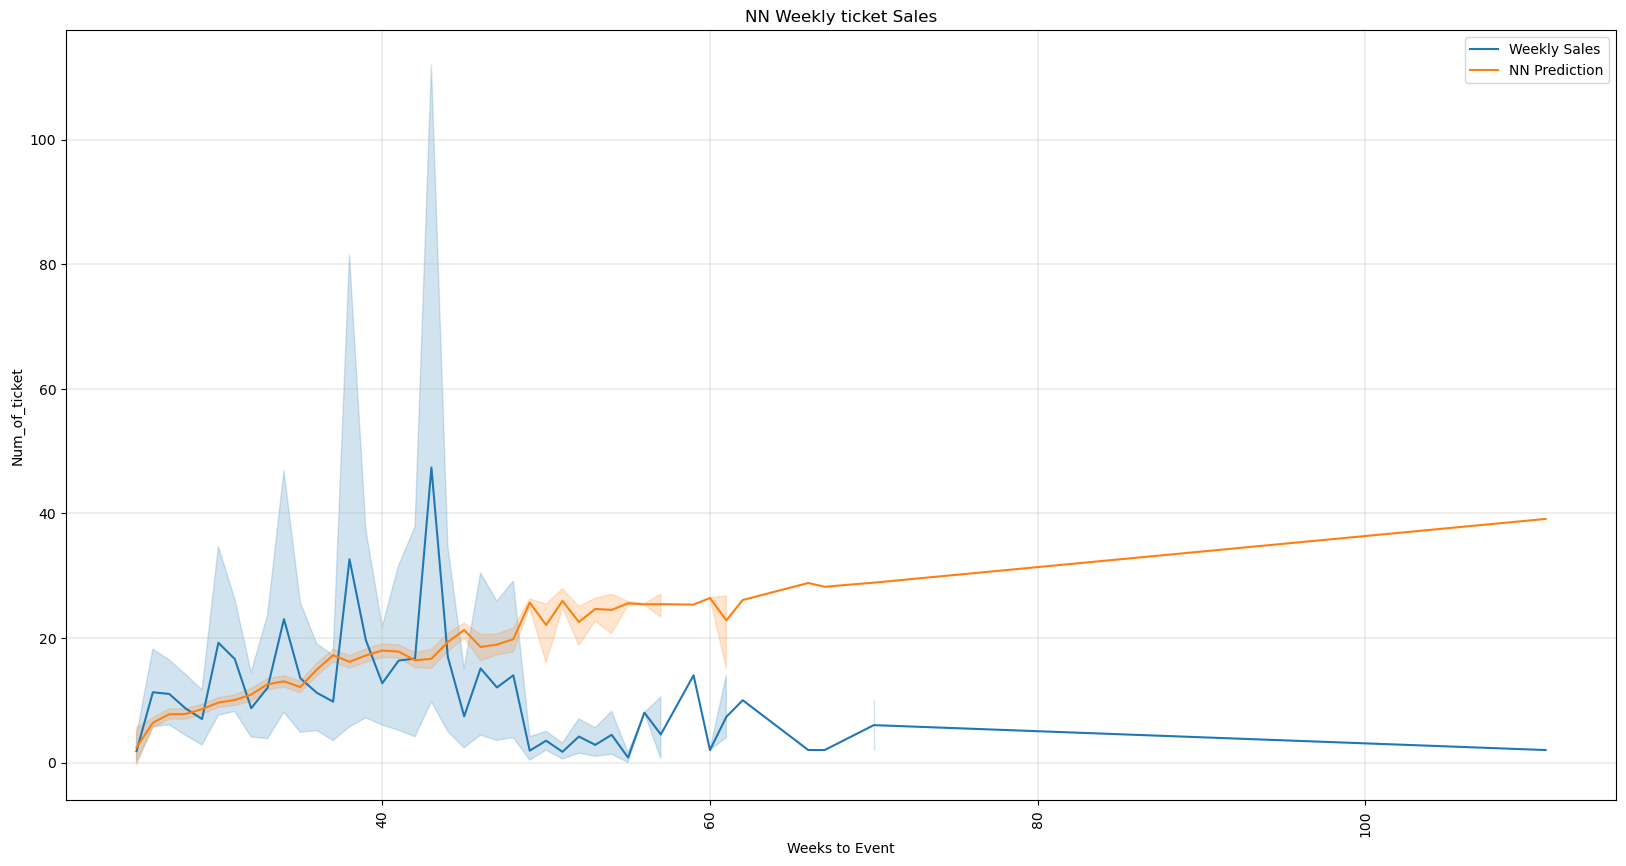

In [33]:
plt.figure(figsize=(20,10), dpi=100)
ax = sns.lineplot(x=test_NN_client_data['Weeks to Event'], y =test_NN_client_data['Num_of_ticket'], data=test_NN_client_data, label="Weekly Sales")
ax2 = sns.lineplot(x=X_test_NN_client_data['Weeks to Event'], y =X_test_NN_client_data['NNWeeklySales'], data=X_test_NN_client_data, label="NN Prediction")

plt.grid(linestyle='-', linewidth=0.3)
# plt.legend(labels=["Weekly Sales","NN Prediction"])
plt.title('NN Weekly ticket Sales')
ax.tick_params(axis='x', rotation=90)

In [34]:
mse = round(mean_squared_error(y_test_NN_client_data, NNweeklysalespredictions), 2)
print(f"LSTM model MSE is: {mse}")

LSTM model MSE is: 6207.5
